## NN work on DIS reconstruction 4

Trying out things from Ben Nachman's example.

Input file here is currently Delphes H1 without any HFS noise added.

Uses set of variables is E, pt, pz, Empz (redundant but useful?) for both HFS and electron as well as delta phi between HFS and electron.

Has x_meas / x_true resolution plots in bins of true y.

Experimenting with training hyperparameters.

### Learning rate of 1e-4

This gives the best results!  Faster than 1e-5 with less artifacts.


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl


/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Read in the minitree

In [2]:
print('\n np.pi = ')
print(np.pi)


 np.pi = 
3.141592653589793


In [3]:
input_file = 'mini-tree-gen-HFS-etamax9.0.root'

ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['minitree']
print(ur_tree)
ur_tree.show()

pandas_df   =  ur_tree.pandas.df(['*'], entrystop=3e7,flatten=True)

pandas_df.eval( 'gene_e = sqrt( gene_px*gene_px + gene_py*gene_py + gene_pz*gene_pz)', inplace=True )

pandas_df.eval( 'e_e = sqrt( e_px*e_px + e_py*e_py + e_pz*e_pz)', inplace=True )

pandas_df.eval( 'e_pt = sqrt( e_px*e_px + e_py*e_py)', inplace=True )

pandas_df.eval( 'e_phi = arctan2( e_py, e_px )', inplace=True )

pandas_df.eval( 'gene_pt = gen_e_pt', inplace=True )
pandas_df.eval( 'gene_phi = gen_e_phi', inplace=True )

pandas_df.eval( 'dphi = e_phi - HFS_phi', inplace=True )
pandas_df.eval( 'dphi = (abs(dphi)<3.14159265)*(dphi)+(dphi>3.14159265)*(dphi-2*3.14159265) + (dphi<-3.14159265)*(dphi+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi = (dphi>0)*dphi + (dphi<0)*(dphi+2*3.14159265)', inplace=True )


pandas_df.eval( 'gen_dphi = 3.141592653589793', inplace=True )

pandas_df.eval( 'HFS_Empz = HFS_E - HFS_pz', inplace=True )
pandas_df.eval( 'e_Empz = e_e - e_pz', inplace=True )

pandas_df.eval( 'gen_HFS_Empz = gen_HFS_e - gen_HFS_pz', inplace=True )
pandas_df.eval( 'gene_Empz = gene_e - gene_pz', inplace=True )


[b'minitree;1']
<TTree b'minitree' at 0x00013d5257c0>
Q2_e                       (no streamer)              asdtype('>f4')
Q2_sigma                   (no streamer)              asdtype('>f4')
Q2_esigma                  (no streamer)              asdtype('>f4')
Q2_da                      (no streamer)              asdtype('>f4')
gen_Q2                     (no streamer)              asdtype('>f4')
y_e                        (no streamer)              asdtype('>f4')
y_sigma                    (no streamer)              asdtype('>f4')
y_esigma                   (no streamer)              asdtype('>f4')
y_da                       (no streamer)              asdtype('>f4')
HFS_px                     (no streamer)              asdtype('>f4')
HFS_py                     (no streamer)              asdtype('>f4')
HFS_pz                     (no streamer)              asdtype('>f4')
gen_y                      (no streamer)              asdtype('>f4')
e_px                       (no streamer)         

In [4]:
pandas_df

,Q2_e,Q2_sigma,Q2_esigma,Q2_da,gen_Q2,y_e,y_sigma,y_esigma,y_da,HFS_px,...,e_pt,e_phi,gene_pt,gene_phi,dphi,gen_dphi,HFS_Empz,e_Empz,gen_HFS_Empz,gene_Empz
entry,,,,,,,,,,,,,,,,,,,,,
0,468.797363,446.056671,468.797363,493.576904,494.087463,0.068597,0.021113,0.022189,0.019365,21.946800,...,20.895912,-2.841402,22.023188,-2.841402,3.163943,3.141593,1.108887,51.413383,1.013672,54.186996
1,1894.759888,1839.243164,1894.759888,1972.203491,1961.159668,0.297868,0.276675,0.285026,0.269170,-8.184976,...,36.474258,-1.340417,37.752453,-1.340417,3.154179,3.141593,14.824951,38.757668,15.084839,40.115883
2,276.638916,275.250427,276.638916,277.117676,275.729858,0.292298,0.288728,0.290185,0.291074,9.406549,...,13.992063,2.275361,13.946084,2.275361,3.098422,3.141593,15.857819,39.065125,16.263672,38.936760
3,238.202896,238.123535,238.202896,238.850800,247.360428,0.315208,0.314980,0.315085,0.313346,-12.571018,...,12.771819,-0.306055,13.262822,-0.306055,3.051179,3.141593,17.381104,37.800510,15.946594,39.253719
4,338.968628,354.665100,338.968628,315.247253,321.091949,0.580202,0.598781,0.572280,0.609580,-10.682003,...,11.928894,-0.382090,11.299782,-0.382090,3.116822,3.141593,34.583248,23.172871,33.249878,21.950768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82850,670.273315,696.540771,670.273315,645.013794,644.488586,-0.009858,0.028225,0.027160,0.028199,-11.539625,...,26.016937,-1.063816,25.016092,-1.063816,3.189495,3.141593,1.619064,55.744118,1.600708,53.599701
82851,319.102203,311.246521,319.102203,319.882477,318.792084,0.366897,0.350918,0.359775,0.365349,8.577925,...,14.213531,-2.177933,14.199718,-2.177933,3.232355,3.141593,18.893814,34.947262,20.287170,34.913300
82852,1181.045532,1121.059570,1181.045532,1201.989502,1243.584961,0.401450,0.369423,0.389190,0.390836,20.893599,...,26.587864,-2.651498,27.995762,-2.651498,3.097349,3.141593,19.356415,33.039944,20.410950,34.789494


## Set up the machine learning stuff

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os

#os.environ['CUDA_VISIBLE_DEVICES']="0"

print(tf.config.list_physical_devices())

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices = tf.config.list_physical_devices('CPU') 


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
X = np.c_[ pandas_df['gen_HFS_pz'].to_numpy(),
          pandas_df['gen_HFS_e'].to_numpy(),
          pandas_df['gen_HFS_pt'].to_numpy(),
          pandas_df['gen_HFS_Empz'].to_numpy(),
          pandas_df['gene_pz'].to_numpy(),
          pandas_df['gene_e'].to_numpy(),
          pandas_df['gene_pt'].to_numpy(),
          pandas_df['gene_Empz'].to_numpy(),
          pandas_df['gen_dphi'].to_numpy(),
         ]

Y = pandas_df['gen_x'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

GY = pandas_df['gen_y'].to_numpy()

print('\n\n Shape of X')
print( X.shape )

print('\n\n Shape of Y')
print( Y.shape )



 Shape of X
(82855, 9)


 Shape of Y
(82855, 1)


In [7]:
X_train, X_test, Y_train, Y_test, GY_train, GY_test = train_test_split( X, Y, GY, test_size=0.5)



In [8]:
model = Sequential()
model.add(Dense(64, input_dim=9, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))

#opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [9]:
hist = model.fit(X_train, Y_train, epochs=300, batch_size=500, verbose=1, validation_data=(X_test,Y_test))

Epoch 1/300
83/83 [==============================] - 1s 5ms/step - loss: 0.3497 - accuracy: 0.0000e+00 - val_loss: 0.1781 - val_accuracy: 0.0000e+00
Epoch 2/300
83/83 [==============================] - 0s 3ms/step - loss: 0.2144 - accuracy: 0.0000e+00 - val_loss: 0.1462 - val_accuracy: 0.0000e+00
Epoch 3/300
83/83 [==============================] - 0s 3ms/step - loss: 0.1899 - accuracy: 0.0000e+00 - val_loss: 0.1364 - val_accuracy: 0.0000e+00
Epoch 4/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1735 - accuracy: 0.0000e+00 - val_loss: 0.1299 - val_accuracy: 0.0000e+00
Epoch 5/300
83/83 [==============================] - 0s 3ms/step - loss: 0.1611 - accuracy: 0.0000e+00 - val_loss: 0.1226 - val_accuracy: 0.0000e+00
Epoch 6/300
83/83 [==============================] - 0s 3ms/step - loss: 0.1512 - accuracy: 0.0000e+00 - val_loss: 0.1159 - val_accuracy: 0.0000e+00
Epoch 7/300
83/83 [==============================] - 0s 2ms/step - loss: 0.1438 - accuracy: 0.0000e+00 - v

Epoch 56/300
83/83 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.0000e+00 - val_loss: 0.0095 - val_accuracy: 0.0000e+00
Epoch 57/300
83/83 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 0.0000e+00 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 58/300
83/83 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.0000e+00 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 59/300
83/83 [==============================] - 0s 3ms/step - loss: 0.0205 - accuracy: 0.0000e+00 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 60/300
83/83 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 61/300
83/83 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.0000e+00 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 62/300
83/83 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.0000e

83/83 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 111/300
83/83 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 112/300
83/83 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 113/300
83/83 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 114/300
83/83 [==============================] - 0s 3ms/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 115/300
83/83 [==============================] - 0s 3ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 116/300
83/83 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - v

83/83 [==============================] - 0s 4ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 165/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 166/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - val_loss: 9.6058e-04 - val_accuracy: 0.0000e+00
Epoch 167/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 168/300
83/83 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 169/300
83/83 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 170/300
83/83 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 0.0000e+00

83/83 [==============================] - 0s 5ms/step - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 219/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 8.4178e-04 - val_accuracy: 0.0000e+00
Epoch 220/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 221/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 222/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 223/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 9.8334e-04 - val_accuracy: 0.0000e+00
Epoch 224/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0045 - accuracy: 0.0000

Epoch 272/300
83/83 [==============================] - 1s 7ms/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 273/300
83/83 [==============================] - 1s 7ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 8.2182e-04 - val_accuracy: 0.0000e+00
Epoch 274/300
83/83 [==============================] - 1s 7ms/step - loss: 0.0040 - accuracy: 0.0000e+00 - val_loss: 8.4366e-04 - val_accuracy: 0.0000e+00
Epoch 275/300
83/83 [==============================] - 1s 7ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 276/300
83/83 [==============================] - 1s 7ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 9.5033e-04 - val_accuracy: 0.0000e+00
Epoch 277/300
83/83 [==============================] - 1s 7ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 8.3083e-04 - val_accuracy: 0.0000e+00
Epoch 278/300
83/83 [==============================] - 1s 7ms/step - loss: 0.0

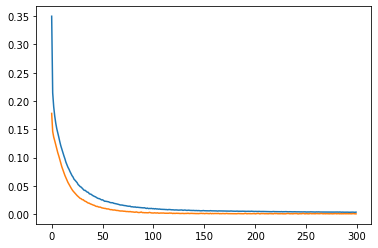

In [10]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [11]:
mypreds = model.predict(X_test,batch_size=1000)

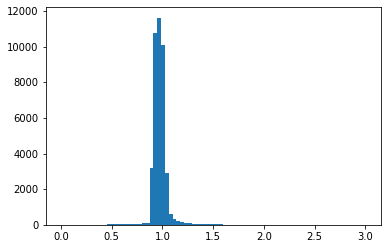

In [12]:
_,_,_=plt.hist(mypreds[:,0]/Y_test[:,0],bins=np.linspace(0,3,80))

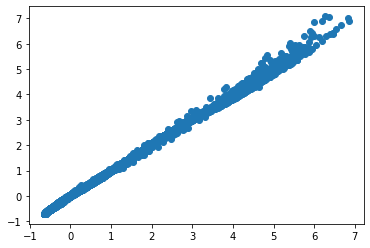

In [13]:
plt.scatter(mypreds[:,0],Y_test[:,0])

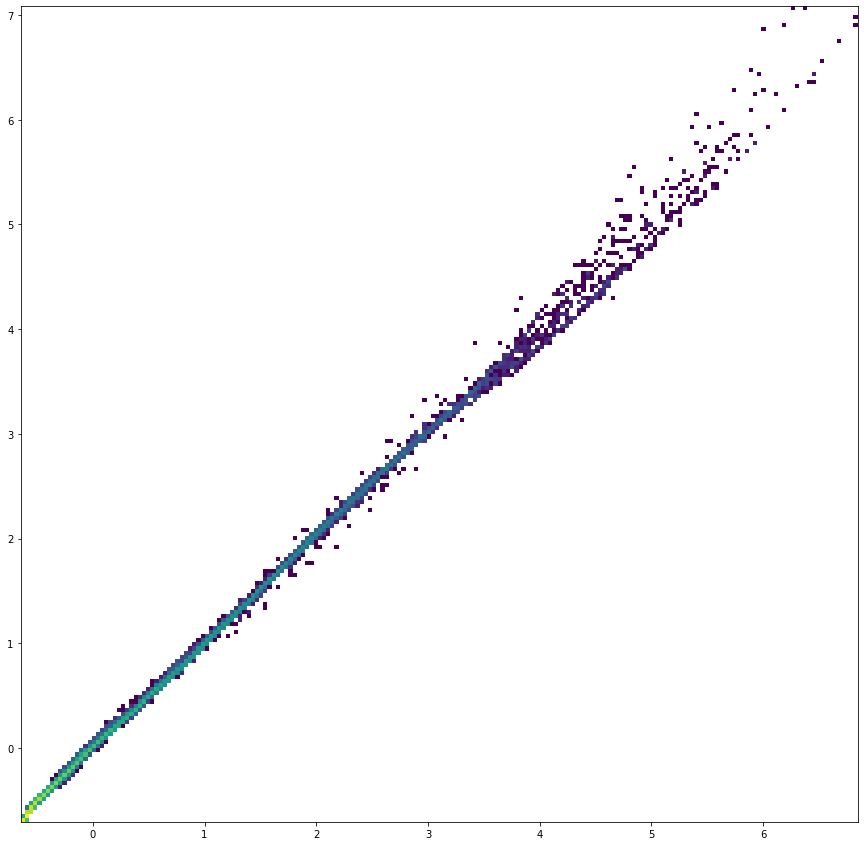

In [14]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds[:,0],Y_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

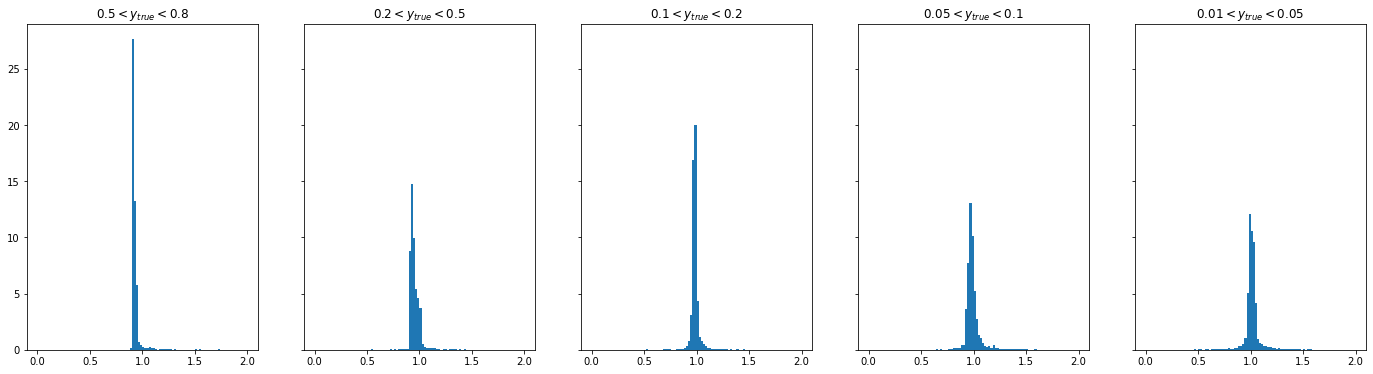

In [15]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

plt.show()


## Some conclusions, gen HFS, gen e

If I feed it the true HFS and scattered electron, the NN can learn how to compute X, which is good, but not surprising.  The longer it trains, the better it gets.  Note that it could figure it all out just from the scattered electron.  Try gen HFS with reco electron.  

In [16]:
X = np.c_[ pandas_df['gen_HFS_pz'].to_numpy(),
          pandas_df['gen_HFS_e'].to_numpy(),
          pandas_df['gen_HFS_pt'].to_numpy(),
          pandas_df['gen_HFS_Empz'].to_numpy(),
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['e_pt'].to_numpy(),
          pandas_df['e_Empz'].to_numpy(),
          pandas_df['dphi'].to_numpy(),
         ]

Y = pandas_df['gen_x'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

GY = pandas_df['gen_y'].to_numpy()


In [17]:
X_train, X_test, Y_train, Y_test, GY_train, GY_test = train_test_split( X, Y, GY, test_size=0.5)



In [18]:
model = Sequential()
model.add(Dense(64, input_dim=9, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))

#opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [19]:
hist = model.fit(X_train, Y_train, epochs=300, batch_size=500, verbose=1, validation_data=(X_test,Y_test))

Epoch 1/300
83/83 [==============================] - 2s 9ms/step - loss: 0.3170 - accuracy: 0.0000e+00 - val_loss: 0.1987 - val_accuracy: 0.0000e+00
Epoch 2/300
83/83 [==============================] - 1s 6ms/step - loss: 0.2255 - accuracy: 0.0000e+00 - val_loss: 0.1712 - val_accuracy: 0.0000e+00
Epoch 3/300
83/83 [==============================] - 1s 6ms/step - loss: 0.2018 - accuracy: 0.0000e+00 - val_loss: 0.1618 - val_accuracy: 0.0000e+00
Epoch 4/300
83/83 [==============================] - 1s 6ms/step - loss: 0.1904 - accuracy: 0.0000e+00 - val_loss: 0.1552 - val_accuracy: 0.0000e+00
Epoch 5/300
83/83 [==============================] - 1s 6ms/step - loss: 0.1802 - accuracy: 0.0000e+00 - val_loss: 0.1498 - val_accuracy: 0.0000e+00
Epoch 6/300
83/83 [==============================] - 0s 6ms/step - loss: 0.1738 - accuracy: 0.0000e+00 - val_loss: 0.1456 - val_accuracy: 0.0000e+00
Epoch 7/300
83/83 [==============================] - 0s 6ms/step - loss: 0.1662 - accuracy: 0.0000e+00 - v

Epoch 56/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0480 - accuracy: 0.0000e+00 - val_loss: 0.0303 - val_accuracy: 0.0000e+00
Epoch 57/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0479 - accuracy: 0.0000e+00 - val_loss: 0.0291 - val_accuracy: 0.0000e+00
Epoch 58/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0461 - accuracy: 0.0000e+00 - val_loss: 0.0285 - val_accuracy: 0.0000e+00
Epoch 59/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0455 - accuracy: 0.0000e+00 - val_loss: 0.0276 - val_accuracy: 0.0000e+00
Epoch 60/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0442 - accuracy: 0.0000e+00 - val_loss: 0.0272 - val_accuracy: 0.0000e+00
Epoch 61/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0431 - accuracy: 0.0000e+00 - val_loss: 0.0259 - val_accuracy: 0.0000e+00
Epoch 62/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0426 - accuracy: 0.0000e

83/83 [==============================] - 0s 4ms/step - loss: 0.0196 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 111/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0195 - accuracy: 0.0000e+00 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 112/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0191 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 113/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0187 - accuracy: 0.0000e+00 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 114/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0185 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 115/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0183 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 116/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0177 - accuracy: 0.0000e+00 - v

83/83 [==============================] - 0s 5ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 165/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0116 - accuracy: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 166/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 167/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 168/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 0.0000e+00 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 169/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 170/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0108 - accuracy: 0.0000e+00 - v

83/83 [==============================] - 0s 4ms/step - loss: 0.0082 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 219/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 220/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 221/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 222/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 223/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 224/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - v

83/83 [==============================] - 0s 4ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 273/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 274/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 275/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 276/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 277/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 278/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - v

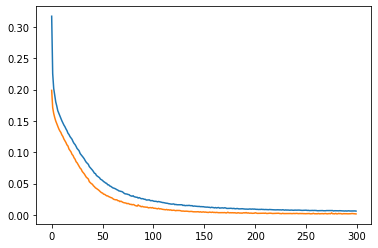

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [21]:
mypreds = model.predict(X_test,batch_size=1000)

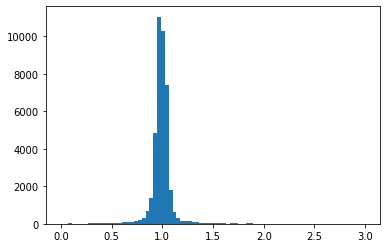

In [22]:
_,_,_=plt.hist(mypreds[:,0]/Y_test[:,0],bins=np.linspace(0,3,80))

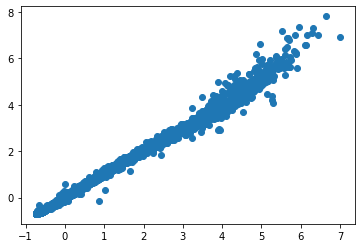

In [23]:
plt.scatter(mypreds[:,0],Y_test[:,0])

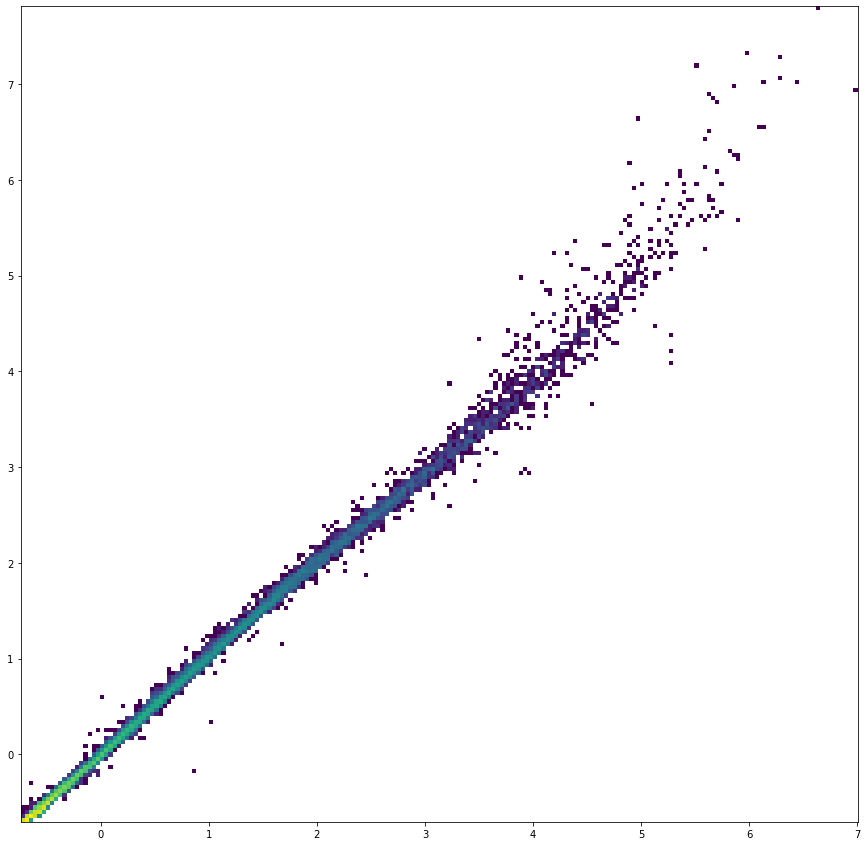

In [24]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds[:,0],Y_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

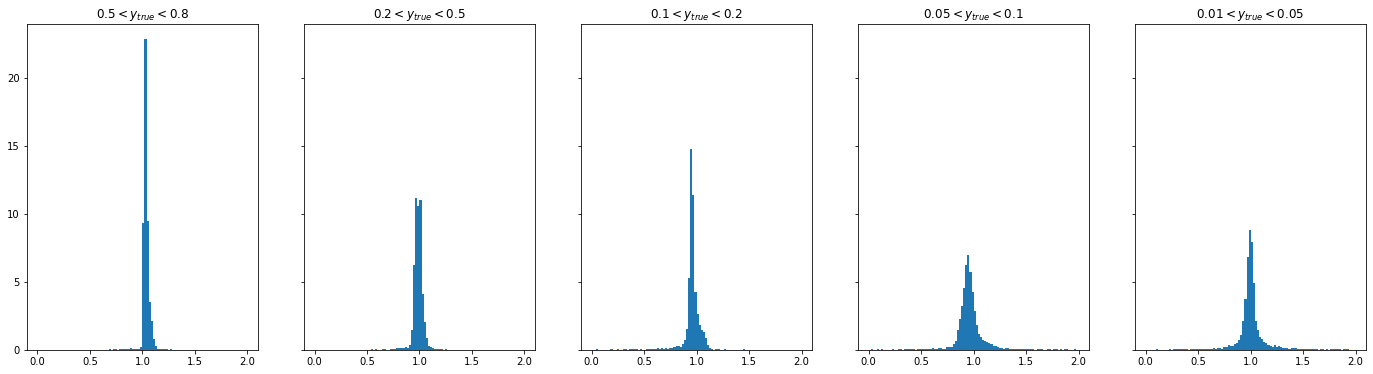

In [25]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

plt.show()


## Conclusions with gen HFS, reco e

Also works pretty well.  Now try with reco everything...

In [26]:
X = np.c_[ pandas_df['HFS_pz'].to_numpy(),
          pandas_df['HFS_E'].to_numpy(),
          pandas_df['HFS_pt'].to_numpy(),
          pandas_df['HFS_Empz'].to_numpy(),
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['e_pt'].to_numpy(),
          pandas_df['e_Empz'].to_numpy(),
          pandas_df['dphi'].to_numpy(),
         ]

Y = pandas_df['gen_x'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

GY = pandas_df['gen_y'].to_numpy()

X_train, X_test, Y_train, Y_test, GY_train, GY_test = train_test_split( X, Y, GY, test_size=0.5)

model = Sequential()
model.add(Dense(64, input_dim=9, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))

#opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [27]:
hist = model.fit(X_train, Y_train, epochs=300, batch_size=500, verbose=1, validation_data=(X_test,Y_test))

Epoch 1/300
83/83 [==============================] - 1s 6ms/step - loss: 0.3078 - accuracy: 0.0000e+00 - val_loss: 0.1287 - val_accuracy: 0.0000e+00
Epoch 2/300
83/83 [==============================] - 0s 4ms/step - loss: 0.1660 - accuracy: 0.0000e+00 - val_loss: 0.1077 - val_accuracy: 0.0000e+00
Epoch 3/300
83/83 [==============================] - 0s 4ms/step - loss: 0.1431 - accuracy: 0.0000e+00 - val_loss: 0.0957 - val_accuracy: 0.0000e+00
Epoch 4/300
83/83 [==============================] - 0s 4ms/step - loss: 0.1284 - accuracy: 0.0000e+00 - val_loss: 0.0890 - val_accuracy: 0.0000e+00
Epoch 5/300
83/83 [==============================] - 0s 4ms/step - loss: 0.1187 - accuracy: 0.0000e+00 - val_loss: 0.0834 - val_accuracy: 0.0000e+00
Epoch 6/300
83/83 [==============================] - 0s 4ms/step - loss: 0.1110 - accuracy: 0.0000e+00 - val_loss: 0.0798 - val_accuracy: 0.0000e+00
Epoch 7/300
83/83 [==============================] - 0s 4ms/step - loss: 0.1051 - accuracy: 0.0000e+00 - v

Epoch 56/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0508 - accuracy: 0.0000e+00 - val_loss: 0.0418 - val_accuracy: 0.0000e+00
Epoch 57/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0505 - accuracy: 0.0000e+00 - val_loss: 0.0409 - val_accuracy: 0.0000e+00
Epoch 58/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0495 - accuracy: 0.0000e+00 - val_loss: 0.0394 - val_accuracy: 0.0000e+00
Epoch 59/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0496 - accuracy: 0.0000e+00 - val_loss: 0.0393 - val_accuracy: 0.0000e+00
Epoch 60/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0483 - accuracy: 0.0000e+00 - val_loss: 0.0392 - val_accuracy: 0.0000e+00
Epoch 61/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0488 - accuracy: 0.0000e+00 - val_loss: 0.0389 - val_accuracy: 0.0000e+00
Epoch 62/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0483 - accuracy: 0.0000e

83/83 [==============================] - 1s 6ms/step - loss: 0.0356 - accuracy: 0.0000e+00 - val_loss: 0.0270 - val_accuracy: 0.0000e+00
Epoch 111/300
83/83 [==============================] - 0s 6ms/step - loss: 0.0343 - accuracy: 0.0000e+00 - val_loss: 0.0271 - val_accuracy: 0.0000e+00
Epoch 112/300
83/83 [==============================] - 0s 6ms/step - loss: 0.0337 - accuracy: 0.0000e+00 - val_loss: 0.0268 - val_accuracy: 0.0000e+00
Epoch 113/300
83/83 [==============================] - 0s 6ms/step - loss: 0.0335 - accuracy: 0.0000e+00 - val_loss: 0.0262 - val_accuracy: 0.0000e+00
Epoch 114/300
83/83 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 0.0000e+00 - val_loss: 0.0261 - val_accuracy: 0.0000e+00
Epoch 115/300
83/83 [==============================] - 0s 6ms/step - loss: 0.0335 - accuracy: 0.0000e+00 - val_loss: 0.0265 - val_accuracy: 0.0000e+00
Epoch 116/300
83/83 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.0000e+00 - v

83/83 [==============================] - 0s 6ms/step - loss: 0.0273 - accuracy: 0.0000e+00 - val_loss: 0.0212 - val_accuracy: 0.0000e+00
Epoch 165/300
83/83 [==============================] - 1s 6ms/step - loss: 0.0274 - accuracy: 0.0000e+00 - val_loss: 0.0214 - val_accuracy: 0.0000e+00
Epoch 166/300
83/83 [==============================] - 0s 6ms/step - loss: 0.0269 - accuracy: 0.0000e+00 - val_loss: 0.0208 - val_accuracy: 0.0000e+00
Epoch 167/300
83/83 [==============================] - 1s 6ms/step - loss: 0.0272 - accuracy: 0.0000e+00 - val_loss: 0.0211 - val_accuracy: 0.0000e+00
Epoch 168/300
83/83 [==============================] - 1s 6ms/step - loss: 0.0269 - accuracy: 0.0000e+00 - val_loss: 0.0207 - val_accuracy: 0.0000e+00
Epoch 169/300
83/83 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.0000e+00 - val_loss: 0.0211 - val_accuracy: 0.0000e+00
Epoch 170/300
83/83 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.0000e+00 - v

83/83 [==============================] - 0s 5ms/step - loss: 0.0231 - accuracy: 0.0000e+00 - val_loss: 0.0181 - val_accuracy: 0.0000e+00
Epoch 219/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0235 - accuracy: 0.0000e+00 - val_loss: 0.0185 - val_accuracy: 0.0000e+00
Epoch 220/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0236 - accuracy: 0.0000e+00 - val_loss: 0.0184 - val_accuracy: 0.0000e+00
Epoch 221/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0229 - accuracy: 0.0000e+00 - val_loss: 0.0182 - val_accuracy: 0.0000e+00
Epoch 222/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0229 - accuracy: 0.0000e+00 - val_loss: 0.0181 - val_accuracy: 0.0000e+00
Epoch 223/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0231 - accuracy: 0.0000e+00 - val_loss: 0.0180 - val_accuracy: 0.0000e+00
Epoch 224/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0222 - accuracy: 0.0000e+00 - v

83/83 [==============================] - 0s 5ms/step - loss: 0.0213 - accuracy: 0.0000e+00 - val_loss: 0.0165 - val_accuracy: 0.0000e+00
Epoch 273/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - val_loss: 0.0170 - val_accuracy: 0.0000e+00
Epoch 274/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - val_loss: 0.0170 - val_accuracy: 0.0000e+00
Epoch 275/300
83/83 [==============================] - 0s 4ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - val_loss: 0.0167 - val_accuracy: 0.0000e+00
Epoch 276/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - val_loss: 0.0163 - val_accuracy: 0.0000e+00
Epoch 277/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - val_loss: 0.0165 - val_accuracy: 0.0000e+00
Epoch 278/300
83/83 [==============================] - 0s 5ms/step - loss: 0.0212 - accuracy: 0.0000e+00 - v

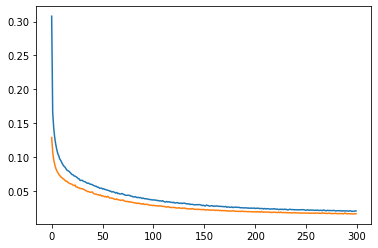

In [28]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [29]:
mypreds = model.predict(X_test,batch_size=1000)

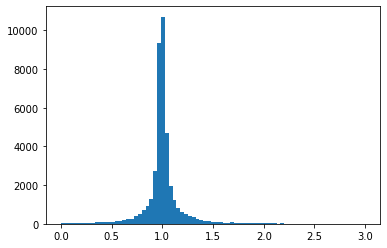

In [30]:
_,_,_=plt.hist(mypreds[:,0]/Y_test[:,0],bins=np.linspace(0,3,80))

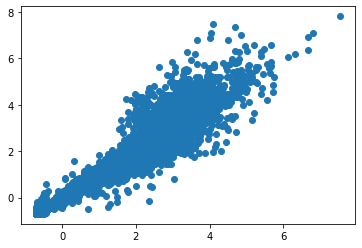

In [31]:
plt.scatter(mypreds[:,0],Y_test[:,0])

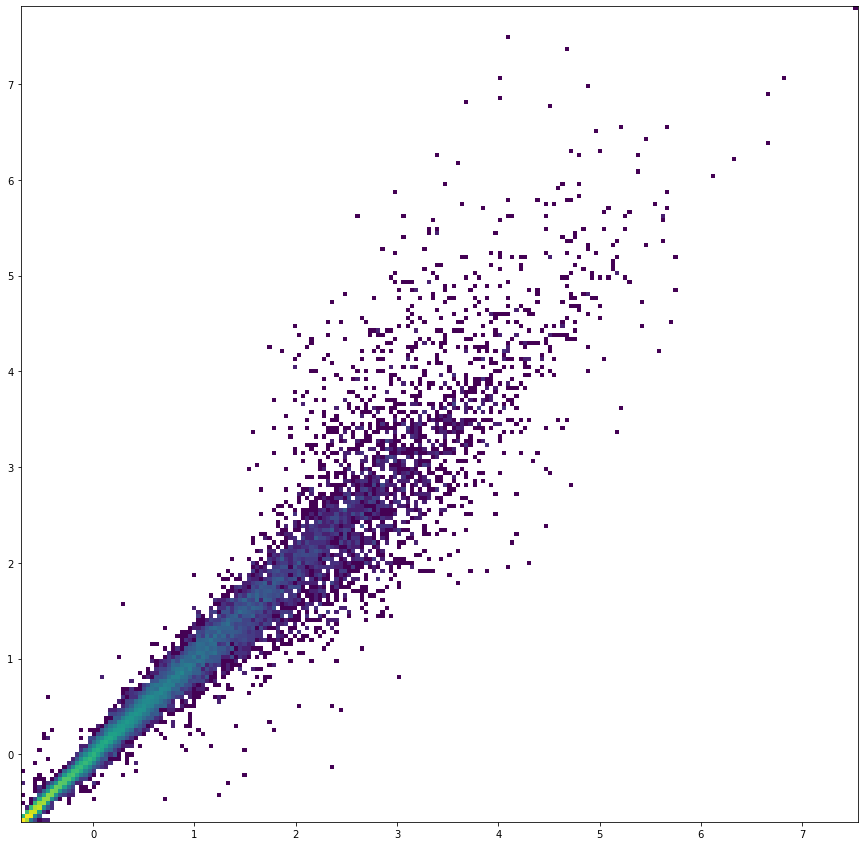

In [32]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds[:,0],Y_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

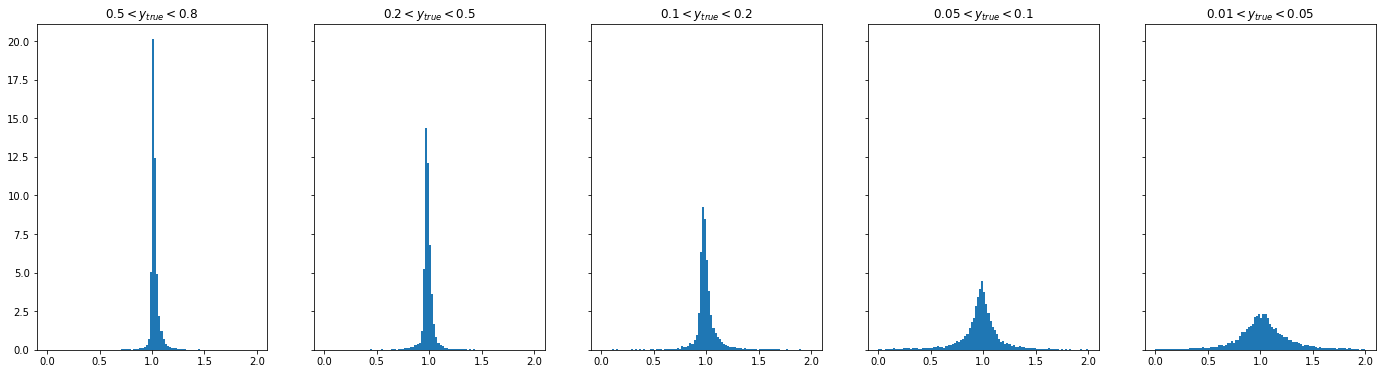

In [33]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

plt.show()

## Some conclusions on reco HFS, reco e

Not too bad, but not perfect.  Hit a plateau in training after several chunks of 300 epochs.